<a href="https://colab.research.google.com/github/macielterra/Python_Analise_Dados/blob/main/Regress%C3%A3o_log%C3%ADstica_com_Python_4Linux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão logística com Python

Para esta aula, estaremos trabalhando com o [Conjunto de dados do Titanic da Kaggle](https://www.kaggle.com/c/titanic). Este é um conjunto de dados muito famoso e muitas vezes é o primeiro passo em Machine Learning.

Vamos tentar montar um algoritmo de classificação (sobrevivente ou falecido) utilizando regressão logística no Python.

Usaremos uma versão "semi-limpa" do conjunto de dados do Titanic. Se você usar o conjunto de dados hospedado diretamente no Kaggle, talvez seja necessário fazer uma limpeza adicional não mostrada neste notebook.

## Importar bibliotecas
Vamos importar algumas bibliotecas para começar!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
! git clone https://github.com/leonardoamorim/datasets

Cloning into 'datasets'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 9
Unpacking objects: 100% (12/12), done.


## Os dados

Vamos começar lendo o arquivo titanic_train.csv em um DataFrame pandas.

In [3]:
train = pd.read_csv('datasets/titanic_train.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [15]:
train['PassengerId']
train['Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [8]:
train['Survived']

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [9]:
! wc -l datasets/titanic_train.csv

892 datasets/titanic_train.csv


In [10]:
train.info()        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Survived (Sobreviveu): 0 = Não, 1 = Sim

Pclass (Classe): Classe de ingresso 1 = 1º, 2 = 2º, 3 = 3º

Sex (Sexo): Sexo do passageiro

Age (Idade): Idade em anos

Sibsp: Quantidade de irmãos / cônjuges a bordo do Titanic

Parch: Quantidade de pais / crianças a bordo do Titanic

Ticket (Bilhete): Número do bilhete de embarque

Fare (Tarifa): Tarifa paga pelo Passageiro

Cabin (Cabine): Número de cabine

Embarked (Embarque): Porto de Embarque (C = Cherbourg, Q=Queenstown, S = Southampton)

# Análise exploratória de dados 

Vamos começar algumas análises de dados exploratórios. Começaremos por verificar os dados que faltam!

## Dados ausentes

Podemos usar seaborn para criar um mapa de calor simples para ver onde estamos perdendo dados!

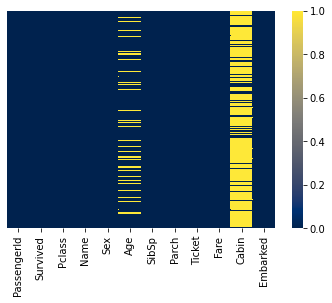

In [21]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=True,cmap='cividis');

Aproximadamente 20% dos dados de idade estão faltando. A proporção de idade que falta é provavelmente pequena o suficiente para que possamos fazer uma substituição razoável com alguma forma de imputação de dados. Olhando para a coluna Cabin, porém, parece que estamos perdendo muito desses dados para fazermos o mesmo. Provavelmente vamos descartar isso mais tarde ou mudá-lo para outro "Cabin Conhecido: 1 ou 0"

Continuemos visualizando mais alguns dos dados!

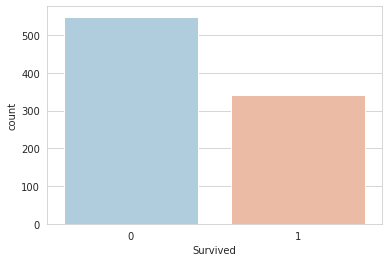

In [22]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

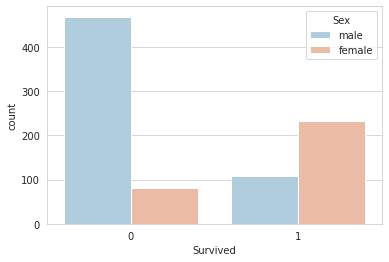

In [23]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

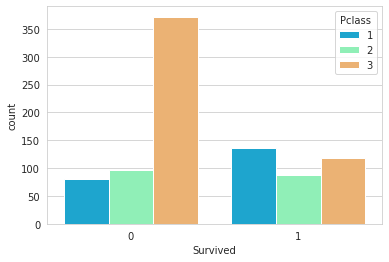

In [24]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

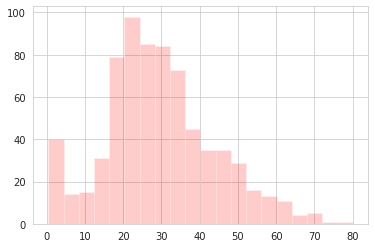

In [32]:
train['Age'].hist(bins=20,color='red',alpha=0.2)

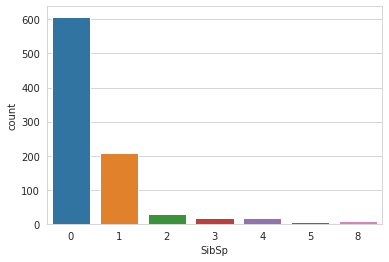

In [33]:
sns.countplot(x='SibSp',data=train)

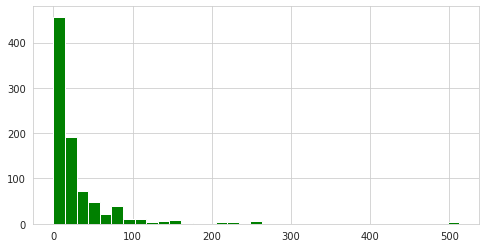

In [43]:
train['Fare'].hist(color='green',bins=35,figsize=(8,4));

___
## Limpando os dados

Queremos preencher dados de idade faltantes, em vez de simplesmente deixar cair as linhas de dados de idade que faltam. Uma maneira de fazer isso é preenchendo a idade média de todos os passageiros (imputação).
No entanto, podemos ser mais inteligentes sobre isso e verificar a idade média pela classe de passageiros. Por exemplo:


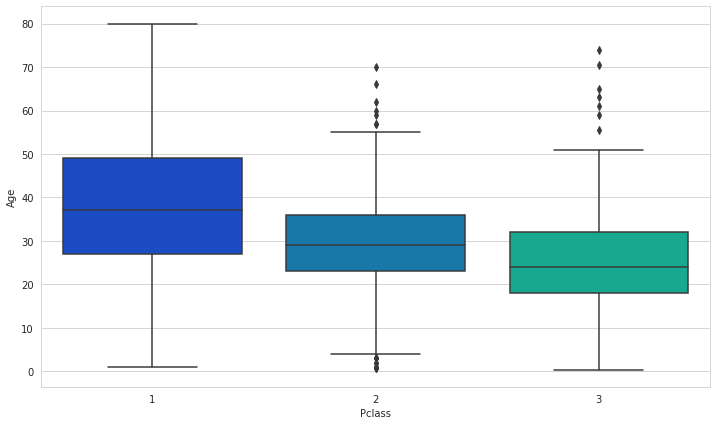

In [44]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Podemos ver os passageiros presumidamente mais ricos (que estão nas classes superiores) tendem a ser mais velhos, o que faz sentido. Usaremos esses valores de idade média para imputar com base em Pclass for Age.

In [45]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Agora aplique essa função!

In [46]:
train['Age'] = train[['Age','Pclass']].apply(impute_age, axis=1)

Agora vamos verificar esse mapa de calor novamente!

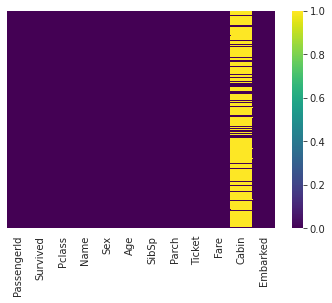

In [47]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=True,cmap='viridis')

In [50]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

Ótimo! Vamos seguir em frente e deletar a coluna Cabin e a linha em Embarked que falta dado.

In [49]:
train.drop('Cabin',axis=1,inplace=True)

In [51]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [52]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [53]:
train.dropna(inplace=True)

In [54]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Convertendo recursos categóricos

Precisamos converter características categóricas em variáveis dummy usando pandas! Caso contrário, nosso algoritmo de Machine Learning não será capaz de aceitar esses recursos diretamente como entradas.

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [56]:
sex = pd.get_dummies(train['Sex'],drop_first=True)  # drop_first=True > Para evitar a multi-colinearidade
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [57]:
embark

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
886,0,1
887,0,1
888,0,1
889,0,0


In [58]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [59]:
sex

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [60]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [61]:
train = pd.concat([train,sex,embark],axis=1)

In [62]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Ótimo! Nossos dados estão prontos para o nosso modelo

# Construindo um modelo de Regressão Logística

Vamos começar dividindo nossos dados em um conjunto de treinamento e conjunto de testes (há outro arquivo titanic_test.csv que você pode usar ao invés, caso queira usar todos esses dados para treinar).

## Divisão treino-teste

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

In [65]:
X_test

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
511,512,3,24.0,0,0,8.05,1,0,1
613,614,3,24.0,0,0,7.75,1,1,0
615,616,2,24.0,1,2,65.00,0,0,1
337,338,1,41.0,0,0,134.50,0,0,0
718,719,3,24.0,0,0,15.50,1,1,0
...,...,...,...,...,...,...,...,...,...
792,793,3,24.0,8,2,69.55,0,0,1
828,829,3,24.0,0,0,7.75,1,1,0
732,733,2,29.0,0,0,0.00,1,0,1
669,670,1,37.0,1,0,52.00,0,0,1


## Treinamento e inferência

In [66]:
from sklearn.linear_model import LogisticRegression

In [68]:
logmodel = LogisticRegression(max_iter=500)
logmodel = logmodel.fit(X_train,y_train)

In [69]:
predictions = logmodel.predict(X_test)

Vamos seguir em frente para avaliar o nosso modelo!

## Avaliação

Podemos verificar a precisão, o recall e a pontuação f1 usando o relatório de classificação!

In [70]:
from sklearn.metrics import classification_report

In [71]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.87       163
           1       0.84      0.69      0.76       104

    accuracy                           0.83       267
   macro avg       0.83      0.80      0.81       267
weighted avg       0.83      0.83      0.82       267



Não foi tão ruim! Você pode querer explorar outros recursos no outro arquivo titanic_text.csv. Algumas sugestões:

* Tente pegar o título (Dr., Sr., Sra., Etc.) do nome como parâmetro.
* Talvez a cabine possa ser uma característica.
* Existe alguma informação que você pode obter do bilhete?

In [75]:
logmodel.predict([[5,	3, 35.0, 0, 0, 8.0500, 1,	0,	1]])
# PassengerId	Pclass Age SibSp Parch Fare	male Q S

array([0])

## Testando com o KNN:

In [76]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15)

In [77]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [78]:
predictions = knn.predict(X_test)

In [79]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.67      0.90      0.77       163
           1       0.67      0.31      0.42       104

    accuracy                           0.67       267
   macro avg       0.67      0.60      0.60       267
weighted avg       0.67      0.67      0.63       267



In [81]:
import pandas as pd                              
s = pd.Series(["A", "B", "C", "D", "E"],
              index=[1, 2, 3, 4, 5])

In [ ]:
s